In [1]:
import numpy as np
import pandas as pd
from sklearn.base import clone 
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import r2_score
import json
import sys
import os
# make paths above 'notebooks/' visible for local imports.
# +----------------------------------------------------------------------------+
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

from src.processing import GatherFeatureDatasets
from src.feature_selection import UnsupervisedFeatureSelection as unsup_fs
from src.feature_selection import CustomRFECV
from src import plotting


# Load data

In [2]:
proc = GatherFeatureDatasets(is_p=False)

In [3]:
datadir = '/uufs/chpc.utah.edu/common/home/koper-group3/alysha/magnitudes'
train = pd.read_csv(os.path.join(datadir, 'feature_splits','s.train.csv'))

In [4]:
station_feature_dict, station_meta_dict, feature_names = proc.process_all_stations_datasets(train, 
                                                                  scaler=False,
                                                                  linear_model=False,
                                                                  source_dist_type='dist')

YHB
X shape: (1248, 45), y shape: (1248,)
YHL
X shape: (537, 45), y shape: (537,)
YMR
X shape: (1533, 45), y shape: (1533,)
YHH
X shape: (1222, 45), y shape: (1222,)
B207
X shape: (341, 45), y shape: (341,)
FLWY
X shape: (319, 45), y shape: (319,)
YUF
X shape: (816, 45), y shape: (816,)
YPP
X shape: (189, 45), y shape: (189,)
YNR
X shape: (2090, 45), y shape: (2090,)
YML
X shape: (423, 45), y shape: (423,)
YFT
X shape: (899, 45), y shape: (899,)
LKWY
X shape: (209, 45), y shape: (209,)
YTP
X shape: (391, 45), y shape: (391,)
B206
X shape: (195, 45), y shape: (195,)
YMC
X shape: (1443, 45), y shape: (1443,)
YNM
X shape: (487, 45), y shape: (487,)
B950
X shape: (152, 45), y shape: (152,)
YDD
X shape: (244, 45), y shape: (244,)


In [5]:
feature_names

array(['amp_ratio_1', 'amp_ratio_2', 'amp_ratio_3', 'amp_ratio_4',
       'amp_ratio_5', 'amp_ratio_6', 'amp_ratio_7', 'amp_ratio_8',
       'amp_ratio_9', 'amp_ratio_10', 'amp_ratio_11', 'amp_ratio_12',
       'amp_ratio_13', 'amp_ratio_14', 'amp_ratio_15', 'amp_ratio_16',
       'amp_ratio_17', 'amp_ratio_18', 'amp_1', 'amp_2', 'amp_3', 'amp_4',
       'amp_5', 'amp_6', 'amp_7', 'amp_8', 'amp_9', 'amp_10', 'amp_11',
       'amp_12', 'amp_13', 'amp_14', 'amp_15', 'amp_16', 'amp_17',
       'amp_18', 'signal_dominant_frequency', 'signal_dominant_amplitude',
       'noise_max_amplitude', 'signal_max_amplitude', 'signal_variance',
       'noise_variance', 'source_depth_km',
       'source_receiver_distance_logkm',
       'source_receiver_back_azimuth_deg'], dtype='<U32')

In [6]:
feature_plot_names = proc.get_feature_plot_names(18, 'dist')
feature_plot_names

array(['ratio 1', 'ratio 2', 'ratio 3', 'ratio 4', 'ratio 5', 'ratio 6',
       'ratio 7', 'ratio 8', 'ratio 9', 'ratio 10', 'ratio 11',
       'ratio 12', 'ratio 13', 'ratio 14', 'ratio 15', 'ratio 16',
       'ratio 17', 'ratio 18', 'amp. 1', 'amp. 2', 'amp. 3', 'amp. 4',
       'amp. 5', 'amp. 6', 'amp. 7', 'amp. 8', 'amp. 9', 'amp. 10',
       'amp. 11', 'amp. 12', 'amp. 13', 'amp. 14', 'amp. 15', 'amp. 16',
       'amp. 17', 'amp. 18', 'sig. dom. freq.', 'sig. dom. amp.',
       'noise max. amp.', 'sig. max. amp.', 'sig. var.', 'noise var.',
       'depth', 'distance', 'back az.'], dtype='<U15')

# Get features with low-ish pairwise correlation values

In [7]:
corr_thresh = 0.85

In [8]:
selected_feats_dict = {}
for stat in station_feature_dict.keys():
    kept_features = unsup_fs.remove_highly_correlated_features(station_feature_dict[stat]['X_train'], thresh=corr_thresh)
    selected_feats_dict[stat] = kept_features

# Look at low corr features across all stations

In [9]:
cnt_df = pd.DataFrame(selected_feats_dict)
cnt_df.index = feature_plot_names
cnt_df.head()

,YHB,YHL,YMR,YHH,B207,FLWY,YUF,YPP,YNR,YML,YFT,LKWY,YTP,B206,YMC,YNM,B950,YDD
ratio 1,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True
ratio 2,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True
ratio 3,True,True,True,True,True,True,True,True,False,True,True,True,True,True,False,True,True,True
ratio 4,True,True,True,True,True,True,False,True,True,True,True,True,True,False,True,True,True,True
ratio 5,True,False,False,False,False,False,True,False,False,False,False,False,False,True,False,False,False,False


In [10]:
cnt_df.to_csv(os.path.join(datadir, 'feature_selection/lowcorr', 'feature.counts.S.csv'))

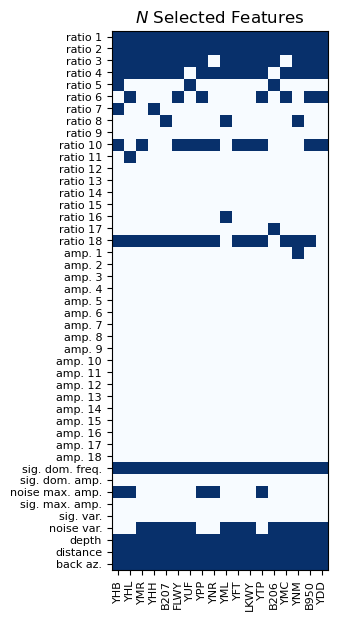

In [11]:
plotting.plot_rfecv_feature_heatmap(cnt_df, 
                                    plot_colorbar=False,
                                    fontsize=8,
                                    figsize=(7, 7),
                                    title='$\it{N}$ Selected Features')

In [12]:
total_cnt_df = CustomRFECV.get_feature_cnts_across_stats(cnt_df)

In [13]:
total_cnt_df[total_cnt_df.cnt > total_cnt_df['cnt'].quantile(0.75)].sort_values(['cnt', 'index'], ascending=False)

,index,cnt
36,sig. dom. freq.,18
1,ratio 2,18
0,ratio 1,18
43,distance,18
42,depth,18
44,back az.,18
3,ratio 4,16
2,ratio 3,16
17,ratio 18,15
41,noise var.,13


In [14]:
np.sort(total_cnt_df[total_cnt_df.cnt > total_cnt_df['cnt'].quantile(0.75)]['index'].values)

array(['back az.', 'depth', 'distance', 'noise var.', 'ratio 1',
       'ratio 10', 'ratio 18', 'ratio 2', 'ratio 3', 'ratio 4',
       'sig. dom. freq.'], dtype=object)